Faça o upload de um arquivo .zip com os seus dados e use o comando abaixo após a finalização do upload para a extração do conteúdo do arquivo no colab.

In [1]:
#  Download e unzip dataset e muda o working dir para o dataset

### dataset 2
# !gdown 1gCYMcfIxSLhKyCyCpk6kv5oHfSyXVb_b
# !unzip -qq dataset-2.zip
# !ls -la
# %cd dataset-2


### dataset 3
# !gdown 1QJ2TkPAXyupIPWAAk1dpYcy44VGhMHC4
# !unzip -qq dataset-3.zip
# !ls -la
# %cd dataset-3


### dataset 4
# !gdown
# !unzip -qq dataset-4.zip
# !ls -la
# %cd dataset-4


### dataset 5 - Hugo
#!gdown 1mQuWgc-Zw1puvjFPTMr2Blht3HSSbwvf
#!unzip -qq dataset-5.zip
#!ls -la
#%cd dataset-5

### dataset 6 - Hugo
#!gdown 1X-u2doVBvOj7iWEDPjB1rMQlJ9qgpWKY
#!unzip -qq dataset-6.zip
#!ls -la
#%cd dataset-6

### dataset 7 - Hugo
!gdown 1vJpktwXMPsNY3H4Cew-_W--QSGmD3fxC
!unzip -qq dataset-7.zip
!ls -la
%cd dataset-7

Downloading...
From (original): https://drive.google.com/uc?id=1vJpktwXMPsNY3H4Cew-_W--QSGmD3fxC
From (redirected): https://drive.google.com/uc?id=1vJpktwXMPsNY3H4Cew-_W--QSGmD3fxC&confirm=t&uuid=7d5c902f-02f4-4507-a99c-bc2722764674
To: /content/dataset-7.zip
100% 274M/274M [00:05<00:00, 49.7MB/s]
total 267656
drwxr-xr-x 1 root root      4096 Jun 30 19:36 .
drwxr-xr-x 1 root root      4096 Jun 30 19:35 ..
drwxr-xr-x 4 root root      4096 Jun 27 13:25 .config
drwxr-xr-x 3 root root      4096 Jun 30 19:36 dataset-7
-rw-r--r-- 1 root root 274056643 Jun 30 19:36 dataset-7.zip
drwxr-xr-x 1 root root      4096 Jun 27 13:26 sample_data
/content/dataset-7


Implemente as funções a seguir.

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torchvision.transforms import v2
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
from torchvision.transforms import functional as F
import skimage.transform as sktransform
import os
import random
from skimage import io

In [3]:
class CarSimDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        original_img_path = sample[0]


        img_path = original_img_path.replace('\\', '/').split('/')[-1]
        img_path = f'/content/dataset-7/IMG/{img_path}'
        print(f'Loading image from path: {img_path}')

        angle = sample[1]

        # Read image and shape it to 28x28
        img = Image.open(img_path)
        img = self.transform(img)

        return img, torch.tensor(angle, dtype=torch.float32)

In [4]:
tfms = v2.Compose([
    v2.Resize((28, 28)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

def preprocess(image, top_offset=.375, bottom_offset=.125):
  top = int(top_offset * image.shape[0])
  bottom = int(bottom_offset * image.shape[0])
  image = sktransform.resize(image[top:-bottom, :], (28, 28, 3))
  return tfms(image)

Crie as variáveis a seguir a partir da classe implementada acima.

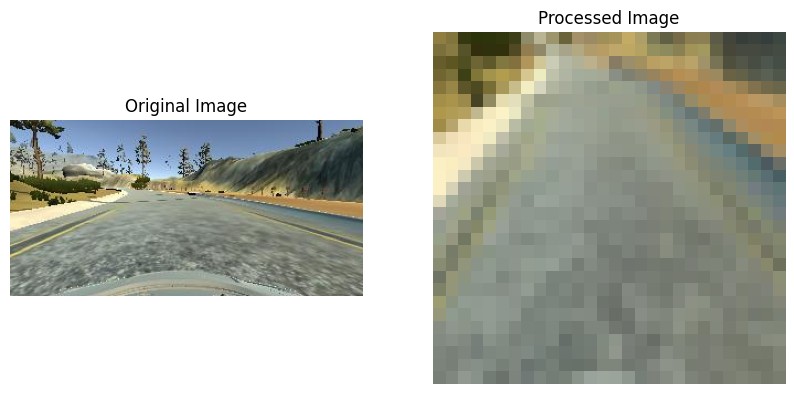

In [5]:
image_folder = '/content/dataset-7/IMG'
images = os.listdir(image_folder)

# Selecionando uma imagem aleatória
random_image = random.choice(images)
image_path = os.path.join(image_folder, random_image)

# Carregando a imagem
image = io.imread(image_path)

# Processando a imagem
processed_image = preprocess(image)

# Convertendo o tensor de volta para imagem PIL para visualização
processed_image = v2.ToPILImage()(processed_image)

# Plotando as imagens original e processada lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(processed_image)
axs[1].set_title('Processed Image')
axs[1].axis('off')

plt.show()

In [6]:
def balance_data(data, num_bins=100, samples_per_bin=200):
    hist, bins = np.histogram(data['angle'], num_bins)
    remove_list = []

    for j in range(num_bins):
        bin_indices = []
        for i in range(len(data)):
            if data['angle'][i] >= bins[j] and data['angle'][i] <= bins[j+1]:
                bin_indices.append(i)
        bin_indices = shuffle(bin_indices)
        bin_indices = bin_indices[samples_per_bin:]
        remove_list.extend(bin_indices)

    print('removed:', len(remove_list))
    data.drop(data.index[remove_list], inplace=True)
    print('remaining:', len(data))

    return data

In [7]:
 # Load the full dataset
data_path = '/content/dataset-7/driving_log.csv'
full_data = pd.read_csv(data_path)
full_data.columns = ['Center','Left','Right','angle','1','2','speed']
print(f'Tamanho do dataset original: {len(full_data)}')

full_data = balance_data(full_data)

# Split the dataset into training and test sets
train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=42)
print(f'Tamanho do dataset de treino: {len(train_data)}')
print(f'Tamanho do dataset de teste: {len(test_data)} ')

# Corrigindo os valores do ângulo
train_data_center = train_data[['Center','angle']].values.tolist()
train_data_left = [(row[0], row[1] + 0.25) for row in train_data[['Left','angle']].values.tolist()]
train_data_right = [(row[0], row[1] - 0.25) for row in train_data[['Right','angle']].values.tolist()]

# Combinando os dados de treino
train_data_list = train_data_center + train_data_left + train_data_right
print(f'train_data_list: {len(train_data_list)}')

# Corrigindo os valores do ângulo para o conjunto de teste
test_data_center = test_data[['Center','angle']].values.tolist()
test_data_left = [(row[0], row[1] + 0.25) for row in test_data[['Left','angle']].values.tolist()]
test_data_right = [(row[0], row[1] - 0.25) for row in test_data[['Right','angle']].values.tolist()]

# Combinando os dados de teste
test_data_list = test_data_center + test_data_left + test_data_right
print(f'test_data_list: {len(test_data_list)}')

###### Create the datasets
training_data = CarSimDataset(train_data_list, preprocess)
testing_data = CarSimDataset(test_data_list, preprocess)
print(f'tamanho dataset training: {len(training_data)}')
print(f'tamanho dataset testing: {len(testing_data)}')

####### Create the datasets with only center images
#training_data = CarSimDataset(train_data_center, preprocess)
#test_data = CarSimDataset(test_data_center, preprocess)

Tamanho do dataset original: 6666
removed: 3373
remaining: 3293
Tamanho do dataset de treino: 2634
Tamanho do dataset de teste: 659 
train_data_list: 7902
test_data_list: 1977
tamanho dataset training: 7902
tamanho dataset testing: 1977


In [8]:
train_data_list[0]

['D:\\term1-simulator-windows\\beta_simulator_windows\\track\\dataset-7\\IMG\\center_2024_06_30_11_28_23_772.jpg',
 -0.05263158]

In [12]:
type(train_data_list)

list

In [14]:
type(training_data)

__main__.CarSimDataset

In [16]:
len(training_data)

7902

In [15]:
print(len(test_data))
print(len(train_data))

659
2634


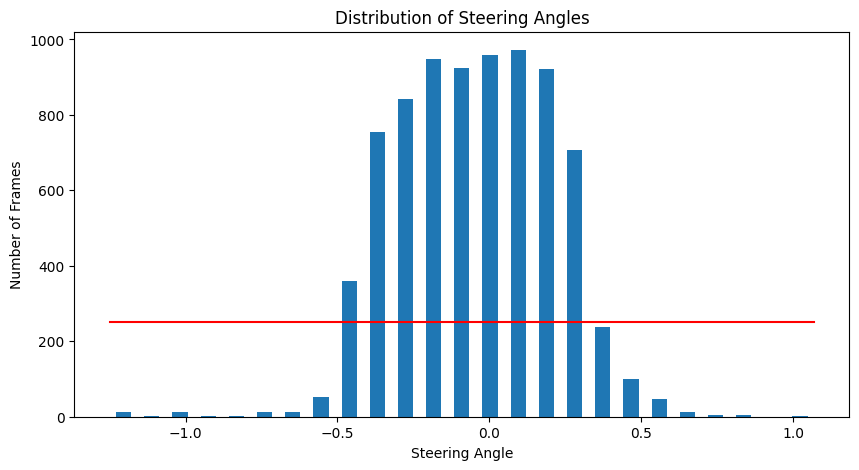

Total training data: 7902


In [ ]:
# Extract steering angles from the training data
train_angles = [sample[1] for sample in train_data_list]

# Plot histogram
num_bins = 25
samples_per_bin = 250
hist, bins = np.histogram(train_angles, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5

plt.figure(figsize=(10, 5))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(train_angles), np.max(train_angles)), (samples_per_bin, samples_per_bin), 'r-')
plt.title('Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Number of Frames')
plt.show()

print('Total training data:', len(train_data_list))

In [ ]:
# training_data = CarSimDataset(...)
# test_data = CarSimDataset(...)

O código abaixo será utilizado para treinar o modelo com o seu dataset.

In [ ]:
full_data.columns = ['Center','Left','Right','angle','1','2','speed']
print(len(full_data))

3293


In [ ]:
full_data.head(10)

,Center,Left,Right,angle,1,2,speed
0,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,0.000000,0.000000,0.0,25.21394
2,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,0.000000,0.000000,0.0,24.86071
4,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,0.022556,0.095720,0.0,24.47523
5,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,0.037594,0.000000,0.0,24.37589
7,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,0.022556,0.193157,0.0,24.04576
9,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,-0.157895,0.068977,0.0,23.94636
10,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,-0.187970,0.261528,0.0,23.90085
11,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,-0.225564,0.036865,0.0,23.83197
12,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,-0.300752,0.231416,0.0,23.70797
13,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,D:\term1-simulator-windows\beta_simulator_wind...,-0.278195,0.083850,0.0,23.70293


In [ ]:
training_data

In [ ]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0,len(testing_data)-1)
img, angle = training_data[random_index][0]
print(f'Forma da imagem: {img.shape}')
print(f'Ângulo: {angle}')

# Plot image
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(training_data[random_index][1])

AttributeError: shape

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

KeyError: 0

In [ ]:
print(len(test_dataloader))
print(len(train_data_list))

11
7902


In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits.squeeze()

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(0) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f" Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

A saída de streaming foi truncada nas últimas 5000 linhas.
right_2024_06_29_22_54_42_134.jpg
right_2024_06_29_22_55_13_467.jpg
right_2024_06_29_22_52_09_384.jpg
right_2024_06_29_22_51_32_084.jpg
right_2024_06_29_22_55_20_024.jpg
right_2024_06_29_22_55_04_052.jpg
right_2024_06_29_22_53_17_920.jpg
right_2024_06_29_22_55_03_197.jpg
right_2024_06_29_22_54_53_261.jpg
right_2024_06_29_22_55_15_484.jpg
right_2024_06_29_22_51_26_709.jpg
right_2024_06_29_22_51_45_081.jpg
right_2024_06_29_22_55_05_180.jpg
right_2024_06_29_22_54_21_765.jpg
right_2024_06_29_22_53_18_135.jpg
right_2024_06_29_22_52_45_424.jpg
right_2024_06_29_22_53_29_381.jpg
right_2024_06_29_22_52_11_409.jpg
right_2024_06_29_22_51_19_986.jpg
right_2024_06_29_22_56_09_092.jpg
right_2024_06_29_22_51_46_555.jpg
right_2024_06_29_22_54_00_599.jpg
right_2024_06_29_22_53_30_305.jpg
right_2024_06_29_22_55_55_057.jpg
right_2024_06_29_22_55_08_328.jpg
right_2024_06_29_22_53_13_307.jpg
right_2024_06_29_22_55_06_088.jpg
right_2024_06_29_22_55_

In [ ]:
torch.save(model.state_dict(), "model6.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Faça o download do seu modelo após o treinamento, caso queira testá-lo no simulador.

O código a seguir demonstra como o modelo será usado para inferência no simulador. Caso seja necessário, altere a função *preprocess*.

In [ ]:
tfms = v2.Compose([
    v2.Resize((28, 28)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

def preprocess(image):
    return tfms(image)

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
model.eval()
x = test_data[0][0]
with torch.no_grad():
    x = preprocess(x)
    print(x.shape)
    x = x.to(device)
    pred = model(x)

torch.Size([3, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x784 and 2352x512)